In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
import datasets
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from bleu import list_bleu
import sacrebleu

In [2]:
file_path = 'lyrics/ds2.csv'

In [3]:
lyric = pd.read_csv(file_path)

In [4]:
lyric = lyric['lyrics'].dropna().reset_index(drop=True)
print(lyric.shape)

(5911066,)


In [5]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
size = lyric.shape[0]
print(size)
max_length = 1024
lyric = lyric.astype(str)

d:\ProgramData\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


5911066


In [6]:
test_size = size % 10000
eval_size = 1000
train_size = 100000
print(train_size, eval_size, test_size)

100000 1000 1066


In [7]:
train_lyric = lyric[:train_size]
eval_lyric = lyric[train_size:train_size+eval_size]
test_lyric = lyric[train_size+eval_size:train_size+eval_size+test_size]
print(train_lyric[0])
print(len(train_lyric[0].split()))

[Chorus: Opera Steve & Cam'ron]
Killa Cam, Killa Cam, Cam
Killa Cam, Killa Cam
Killa Cam, Cam
Killa Cam, Killa Cam, Cam
Killa Killa Killa Cam
Killa Cam, Cam, Killa (Killa!)
Killa Cam, Killa Cam, Cam (Bases loaded)
Killa Cam, Killa Cam (Uh-huh)
Killa Cam, Cam (Santana on second, Jim on third)
Killa Cam, Killa Cam, Cam (I'm at bat)
Killa Killa Killa Cam
Killa Cam, Cam, Killa (I'm 'bout to hit this shit out the world)
Killa Cam (Ugh, Heatmakerz), Killa Cam, Cam
Killa Cam, Killa Cam
Killa Cam, Cam (Hahahaha)
Killa Cam, Killa Cam, Cam
Killa Killa Killa Cam
Killa Cam, Cam, Killa (We  make this shit clap)
Killa Cam, Killa Cam, Cam
Killa Cam, Killa Cam
Killa Cam, Cam
Killa Cam, Killa Cam, Cam
Killa Killa Killa Cam (Killa! Killa!)
Killa Cam, Cam, Killa
[Verse 1]
With the goons I spar, stay in tune with ma (What up?)
She like, "Damn, this the realest since 'Kumbaya'"
Bomaye, Killa Cam, my Lord (My Lord)
Still the man with the pan, scrilla, fam, on board
Now bitches, they want to neuter me, nigga

In [8]:
tokenizer.padding_side = "left"

In [10]:
tokenizer.padding_side = "left"
tokenized_lyric = []
for i in range(size):
    text = lyric[i]
    tokenized_lyric.append(tokenizer(text, max_length=max_length, truncation=True, padding='max_length', return_tensors="pt"))
    tokenized_lyric[i]['labels'] = tokenized_lyric[i]['input_ids'].clone()
tokenized_lyric

KeyboardInterrupt: 

In [ ]:
train_tokenized_lyric = tokenized_lyric[:train_size]
eval_tokenized_lyric = tokenized_lyric[train_size:train_size+eval_size]
test_tokenized_lyric = tokenized_lyric[train_size+eval_size:train_size+eval_size+test_size]

In [ ]:
train_arguments = TrainingArguments(
    output_dir="./lyric_results",
    evaluation_strategy='epoch',
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    # val_check_interval=0.1,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_tokenized_lyric,
    tokenizer=tokenizer,
    eval_dataset=eval_tokenized_lyric,
)

trainer.train()

model.save_pretrained("./lyric_model_2")


In [9]:
model = GPT2LMHeadModel.from_pretrained("./lyric_model_2")
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

d:\ProgramData\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
gpt = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")

In [11]:
import sacrebleu

In [12]:
test_lyric = test_lyric.reset_index(drop=True).astype(str)
test_lyric

0       [Verse One]\nWhile you take off them Vicky’s\n...
1       [Verse 1]\nJe kan niet fokken met het ultieme,...
2       Genesis 26:1: And there was a famine in the la...
3       [Intro: R.Can]\nJordi Barre, R.can\nDécloisonn...
4       Genesis 27:1: And it came to pass, that when I...
                              ...                        
1061    [Scratches]:\n"How many niggas do you know lik...
1062    [Songtext zu „Abteilungsleiter der Liebe (Prom...
1063    [Intro]\nViele bunte Farben\nViele, viele, vie...
1064    (VOLUME III: MARIUS; BOOK VIII: THE WICKED POO...
1065    742\n\nFour Trees — upon a solitary Acre\nWith...
Name: lyrics, Length: 1066, dtype: object

In [13]:
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [15]:
bleu1_list = []
bleu2_list = []
for i in trange(test_size):
    lyric_tmp = test_lyric[i]
    # print(type(lyric_))
    # print(lyric_)
    lyric_ = tokenizer(lyric_tmp, max_length=100, truncation=True, padding='max_length', return_tensors="pt")
    output_1 = model.generate(input_ids=lyric_['input_ids'], attention_mask=lyric_['attention_mask'],max_new_tokens=100, num_return_sequences=1,pad_token_id=tokenizer.eos_token_id)
    output_2 = gpt.generate(input_ids=lyric_['input_ids'], attention_mask=lyric_['attention_mask'],max_new_tokens=100, num_return_sequences=1,pad_token_id=tokenizer.eos_token_id)
    bleu1 = sacrebleu.sentence_bleu(tokenizer.decode(output_1[0], skip_special_tokens=True), [lyric_tmp])
    bleu2 = sacrebleu.sentence_bleu(tokenizer.decode(output_2[0], skip_special_tokens=True), [lyric_tmp])
    # print(bleu1.score, bleu2.score)
    bleu1_list.append(bleu1.score)
    bleu2_list.append(bleu2.score)
print(sum(bleu1_list)/len(bleu1_list))
print(np.sum(np.array(bleu1_list) >= np.array(bleu2_list)))

100%|██████████| 1066/1066 [2:13:52<00:00,  7.54s/it] 

12.385039587542995
508


In [16]:
print(sum(bleu2_list)/len(bleu2_list))

12.536496668069818


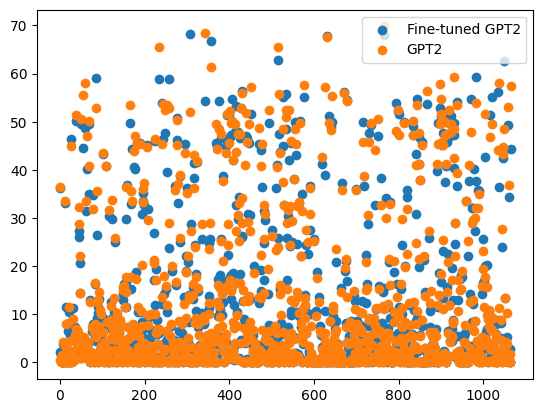

In [19]:
import matplotlib.pyplot as plt
plt.scatter(range(len(bleu1_list)), bleu1_list, label='Fine-tuned GPT2')
plt.scatter(range(len(bleu2_list)), bleu2_list, label='GPT2')
plt.legend()